In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from google.colab import drive
drive.mount('/drive')
import zipfile
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Me-load data
data = pd.read_csv('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv')

# cek isi data teratas
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
# cek isi 5 baris terbawah data
data.tail()

,category,text
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...
2224,sport,souness delight at euro progress boss graeme s...


In [4]:
# cek info data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
# cek distribusi label
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [6]:
# Fungsi untuk menghapus stopwords
def remove_stopwords(kalimat):
    for kata in stopwords.words('english'):
        token = ' '+kata+' '
        kalimat = kalimat.lower().replace(token, ' ')
    return kalimat

In [7]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
padding_type='post'
oov_tok = '-'
data_clean = data.copy()

# Mmebuang stopword pada kalimat
label = data_clean['category']
kalimat = data_clean['text'].apply(lambda u:remove_stopwords(u))

# Split data
kalimat_train, kalimat_test, label_train, label_test = train_test_split(kalimat, 
                                                                        label,
                                                                        test_size=0.2,
                                                                        random_state=42)

# Tokenisasi
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(kalimat_train)
tokenizer.fit_on_texts(kalimat_test)
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(label)

# Konversi teks ke sequence
seq_kalimat_train = tokenizer.texts_to_sequences(kalimat_train)
seq_kalimat_test = tokenizer.texts_to_sequences(kalimat_test)

# Padding teks
padded_seq_kalimat_train = pad_sequences(seq_kalimat_train, padding=padding_type, maxlen=max_length)
padded_seq_kalimat_test = pad_sequences(seq_kalimat_test, padding=padding_type, maxlen=max_length)
label_train_seq = np.array(label_tokenizer.texts_to_sequences(label_train))
label_test_seq = np.array(label_tokenizer.texts_to_sequences(label_test))

In [8]:
tf.random.set_seed(42)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy')>0.95 and (logs.get('val_accuracy') > 0.91):
            print('Acc dan Val Acc sudah >= 91%...')
            self.model.stop_training = True

model = tf.keras.Sequential(name='Simple-BiLSTM', layers=[
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), 
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(6, activation='softmax')
            ])

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), metrics=['accuracy'])

Model: "Simple-BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 200)          93600     
_________________________________________________________________
global_average_pooling1d (Gl (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 130,306
Trainable params: 130,306
Non-trainable params: 0
_______________________________________________

In [9]:
history = model.fit(padded_seq_kalimat_train, label_train_seq, epochs=100,
                    validation_data=(padded_seq_kalimat_test, label_test_seq), 
                    verbose=1,
                    callbacks=[myCallback()])

Epoch 1/100
56/56 [==============================] - 13s 165ms/step - loss: 1.8188 - accuracy: 0.3197 - val_loss: 1.9080 - val_accuracy: 0.2944
Epoch 2/100
56/56 [==============================] - 8s 148ms/step - loss: 0.8551 - accuracy: 0.6736 - val_loss: 0.3481 - val_accuracy: 0.8787
Epoch 3/100
56/56 [==============================] - 8s 149ms/step - loss: 0.5038 - accuracy: 0.8629 - val_loss: 0.4578 - val_accuracy: 0.8247
Epoch 4/100
56/56 [==============================] - 8s 147ms/step - loss: 0.1765 - accuracy: 0.9410 - val_loss: 0.2657 - val_accuracy: 0.9101
Epoch 5/100
56/56 [==============================] - 8s 150ms/step - loss: 0.1188 - accuracy: 0.9612 - val_loss: 0.2848 - val_accuracy: 0.9056
Epoch 6/100
56/56 [==============================] - 8s 150ms/step - loss: 0.0684 - accuracy: 0.9826 - val_loss: 0.4324 - val_accuracy: 0.8719
Epoch 7/100
56/56 [==============================] - 8s 150ms/step - loss: 0.0844 - accuracy: 0.9798 - val_loss: 0.2912 - val_accuracy: 0.932

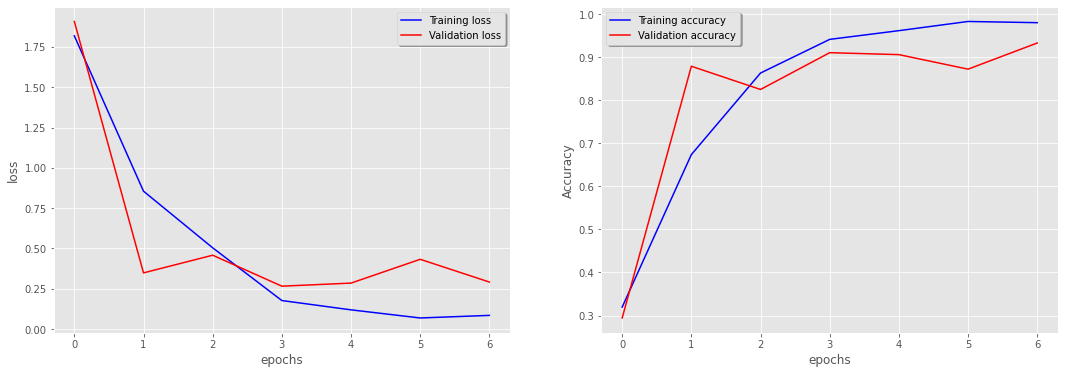

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')    
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='best', shadow=True)